#Initial Configurations

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import os, glob
import cv2
import numpy as np
from skimage import feature

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

path = "/content/drive/MyDrive/Colab_Notebooks/ppgeel-ine410121-visao_computacional/projeto_final/" #Alterar para o caminho da pasta onde está o notebook
os.chdir(path)

!pwd
!uname -a
!cat /etc/lsb-release

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)

/content/drive/MyDrive/Colab_Notebooks/ppgeel-ine410121-visao_computacional/projeto_final
Linux ae8735e42076 6.1.85+ #1 SMP PREEMPT_DYNAMIC Tue Jun 18 14:18:04 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux
DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.3 LTS"
Running on Google Colab =  True


In [ ]:
!git clone https://github.com/michelpf/dataset-pothole.git

fatal: destination path 'dataset-pothole' already exists and is not an empty directory.


In [ ]:
# Install latest OpenCV with Python Interface using the Python Install Program
# !pip3 install opencv-python

# Install the Extreme Gradient Boosting package for Classic Machine Learning
# !pip install xgboost

In [ ]:
%reload_ext autoreload
%autoreload 2

# Make matplotlib draw graphics directly onto the notebook and not in a window
%matplotlib inline

#Dataset Setup

##Reading Images

Total de imagens:  15
Tamano das imagens:  (416, 416)


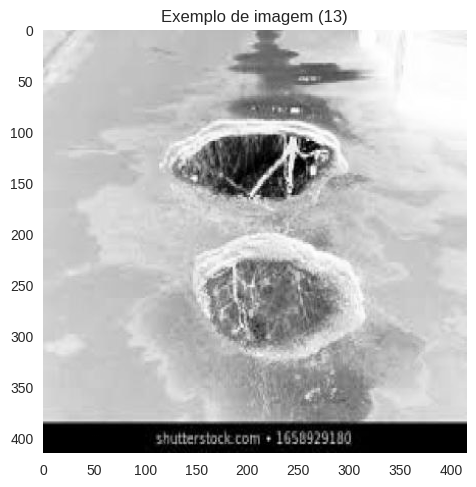

In [ ]:
def read_images(org_path = "dataset-pothole/dataset/train", n_img = 1000):
    img = []
    i = 0
    # Realiza a leitura das imagens em ordem alfabética  e retorna um array de imagens em escala de cinza
    for org_path in sorted(glob.glob(org_path + "/*.jpg")):
        i += 1
        if i > n_img:
          break
        org_image = cv2.imread(org_path)
        # cropped_image = org_image[600:860, 450:1300]
        rgb_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
        img.append(gray_img)

    print("Total de imagens: ", len(img))
    print("Tamano das imagens: ", img[0].shape)
    n = np.random.randint(0, n_img)
    plt.style.use("seaborn-v0_8")
    plt.figure()
    plt.grid(False)
    plt.imshow(img[0])
    plt.title("Exemplo de imagem ({})".format(n))
    return img

img_data = read_images(org_path = "dataset-pothole/dataset/test", n_img = 15)

##Reading Yolo Annotations

In [ ]:
def read_annotations(org_path = "dataset-pothole/dataset/train", n_img = 1000):
    # Realiza a leitura dos dados treinamento em formato "YOLO annotation"
    # image_size = [1920, 1080]
    # new_image_size = [260, 850]
    yolo_data = []
    i=0
    for txt_file in sorted(glob.glob(org_path + "/*.txt")):
        if i > n_img:
            break
        yolo_data.append([])
        with open(txt_file, 'r') as f:
            for line in f:
                values = line.split()
                yolo_data[i].append([float(value) for value in values])
        i=i+1
    print("Exemplo de anotação: ", yolo_data[0][0])
    return yolo_data

yolo_data = read_annotations(org_path = "dataset-pothole/dataset/test", n_img = 15)

Exemplo de anotação:  [0.0, 0.49278846153846156, 0.30649038461538464, 0.45072115384615385, 0.22235576923076922]


##Windowing

Train specitfic data:  (15, 80, 80)  Labels:  (15,)
Train augmmented specitfic data:  (165, 80, 80)  Labels:  (165,)
Train data:  (507, 80, 80)  Labels:  (507,)


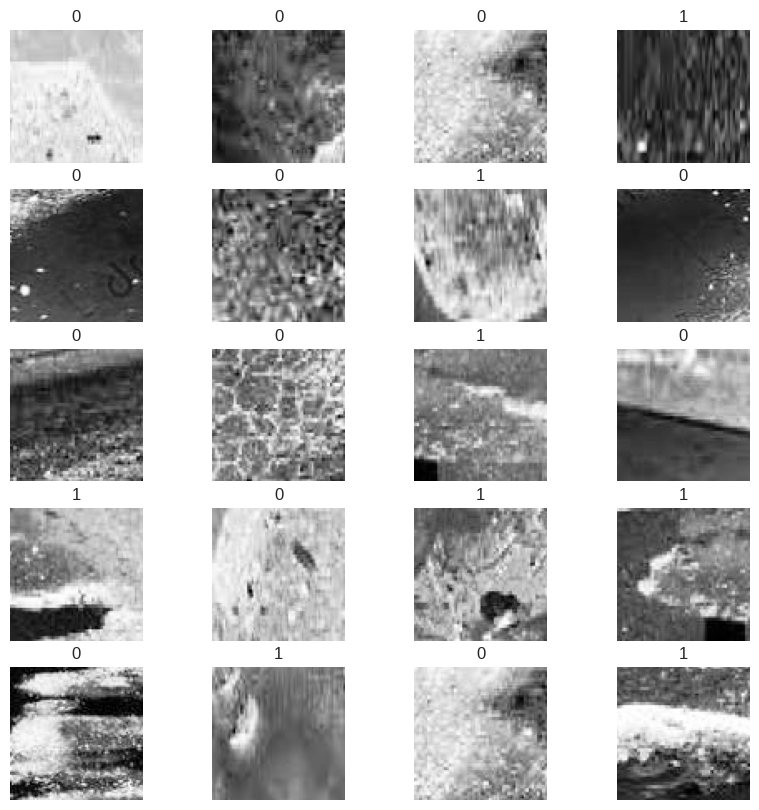

In [ ]:
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import numpy as np
import random

window_size = 80
window_step = 40

def plot_data(img, img_class=0):
  n_img = len(img)
  plt.figure(figsize=(10, 10))
  for i in range(n_img):
      if i>=5*4: break
      n = random.randint(0,n_img-1)
      # if img_class[n]:
      plt.subplot(5, 4, i+1)
      plt.imshow(img[n])
      plt.title(img_class[n])
      plt.axis("off")
  plt.show()

# Recorta a imagem de cada buraco
def pothole_window_extractor(img, pothole_data_l_n, window_size):
    x_center = int(pothole_data_l_n[1]* img.shape[1])
    y_center = int(pothole_data_l_n[2]* img.shape[0])
    x_min = int(x_center - window_size/2)
    x_max = int(x_center + window_size/2)
    y_min = int(y_center - window_size/2)
    y_max = int(y_center + window_size/2)
    if x_min<0 or y_min<0 or x_max > img.shape[1] or y_max > img.shape[0]:
      # print("fail")
      return 0
    pothole_window_n = img[y_min:y_max, x_min:x_max]
    return pothole_window_n

# Recorta a imagem dos buracos do conjunto de imagens
def pothole_windows(images, pothole_data, window_size):
    pothole_window = []
    pothole_window_class = []
    for j in range(len(images)):
      for i in range(len(pothole_data[j])):
        pothole_window_ = pothole_window_extractor(images[j], pothole_data[j][i], window_size)
        if not isinstance(pothole_window_, int):
          pothole_window.append(pothole_window_)
          pothole_window_class.append(1)
    return pothole_window, pothole_window_class

# Verifica se está na região de algum buraco
def region_check(image, wd_y_center, wd_x_center, pothole_data_lines, window_size, window_step):
    for i in range(len(pothole_data_lines)):
      x_diff = abs(pothole_data_lines[i][1]*image.shape[1] - wd_x_center) #Centro_Yolo - Centro_Window (eixo x)
      x_yolo_width = pothole_data_lines[i][3]*image.shape[1] #Yolo_Rectangle_Width
      y_diff = abs(pothole_data_lines[i][2]*image.shape[0] - wd_y_center) #Centro_Yolo - Centro_Window (eixo y)
      y_yolo_width = pothole_data_lines[i][4]*image.shape[0] #Yolo_Rectangle_High
      if ((x_diff<x_yolo_width or x_diff<window_size) and (y_diff<y_yolo_width or y_diff<window_size)):
          if ((x_diff<x_yolo_width/3 or x_diff<window_size/3) and (y_diff<y_yolo_width/3 or y_diff<window_size/3)):
            return 1
          else:
            return -1
    return 0

# Recorta as imagens em janelas
def sliding_windows(image, pothole_data_lines, window_size, window_step, rand = 1000):
    window = []
    window_class = []
    position = []
    image_height = image.shape[0]
    image_width = image.shape[1]
    for y in range(0, image_height-window_size, window_step):
        for x in range(0, image_width-window_size, window_step):
          wd_y_center = y+(window_size/2)
          wd_x_center = x+(window_size/2)
          pothole_region = region_check(image, wd_y_center, wd_x_center, pothole_data_lines, window_size, window_step)
          if pothole_region!=-1 and (pothole_region or random.randint(0, 1000) < rand):
            window.append(image[y:y+window_size, x:x+window_size])
            position.append([x,y])
            if pothole_region:
              window_class.append(1)
            else:
              window_class.append(0)
    return window, window_class, position

# Realiza o "data augmentation" para as imagens que contém buracos
def data_augmentation(input_data):
    augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(factor = 0.2),
    ])
    n_augmentations = 10
    augmented_data_output = []
    for input_img in (input_data):
      input_img = tf.expand_dims(input_img, 0)
      for _ in range(n_augmentations):
        augmented_image = augmentation(input_img)
        augmented_data_output.append(augmented_image[0])
    return augmented_data_output

def prepare_data(img, yolo_data, window_size = 80, window_step = 30):
  pothole_window, pothole_window_class = pothole_windows(img, yolo_data, window_size)

  window = []
  window_class = []
  position = []
  for j in range(len(img)):
      w, w_c, pos = sliding_windows(img[j], yolo_data[j], window_size, window_step, 1000)
      window = window + w
      window_class = window_class + w_c
      position = position + pos

  pothole_window_augmented = data_augmentation(pothole_window)
  pothole_window_augmented = pothole_window + pothole_window_augmented
  pothole_window_augmented_class = [1]*len(pothole_window_augmented)
  window = window + pothole_window_augmented
  window_class = window_class + pothole_window_augmented_class
  x_train = window
  y_train = window_class
  # x_train, x_test, y_train, y_test = train_test_split(window, window_class, test_size=0.3)
  print("Train specitfic data: ", np.array(pothole_window).shape, " Labels: ", np.array(pothole_window_class).shape)
  print("Train augmmented specitfic data: ", np.array(pothole_window_augmented).shape, " Labels: ", np.array(pothole_window_augmented_class).shape)
  print("Train data: ", np.array(x_train).shape, " Labels: ", np.array(y_train).shape)
  # print("Test data: ", np.array(x_test).shape, " Labels: ", np.array(y_test).shape)
  x_train = np.array(x_train)
  y_train= np.array(y_train)
  # x_test = np.array(x_test)
  # y_test = np.array(y_test)
  window = []
  window_class = []
  pothole_window_augmented = []
  pothole_window = []

  return x_train, y_train

x_train, y_train = prepare_data(img_data[0:10], yolo_data[0:10], window_size, window_step)
plot_data(x_train, y_train)

#HoG Feature Extraction

In [ ]:
def plot_hog_data(img):
  n_img = len(img)
  plt.figure(figsize=(10, 10))
  for i in range(n_img):
      if i>=5*4: break
      n=i
      # n = random.randint(0,n_img-1)
      # if img_class[n]:
      plt.subplot(5, 3, i+1)
      plt.imshow(img[n])
      plt.axis("off")
  plt.show()

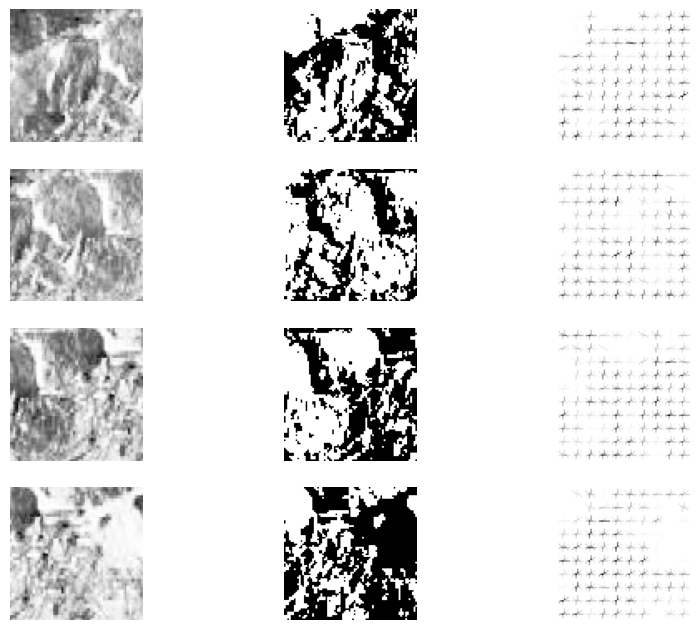

In [ ]:
def quantify_image(image, visualize=False, cell_size=8):
    if visualize:
        # print('Visualisar HoG!')
        features, hog_image = feature.hog(image, orientations=9,
                               pixels_per_cell=(cell_size, cell_size), cells_per_block=(2, 2),
                               visualize=visualize,
                               transform_sqrt=True, block_norm="L1")

        return features, hog_image
    else:
        features = feature.hog(image, orientations=9,
                               pixels_per_cell=(cell_size, cell_size), cells_per_block=(2, 2),
                               transform_sqrt=True, block_norm="L1")

        return features

def prepare_images(img_windows_dataset, visualize=False):
    data = []
    labels = []
    hog_image_list = []

    if visualize:
        for img in img_windows_dataset:
          img_uint16 = (img).astype(np.uint16)
          otsu_image = cv2.threshold(img_uint16, 0, 255,
                                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
          features, hog_image = quantify_image(otsu_image, visualize = visualize)
          hog_image_list.append(img)
          hog_image_list.append(otsu_image)
          hog_image_list.append(hog_image)
          data.append(features)
        return (np.array(data)), hog_image_list

    else:
      for img in img_windows_dataset:
          img_uint16 = (img).astype(np.uint16)
          otsu_image = cv2.threshold(img_uint16, 0, 255,
                                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
          features = quantify_image(img, visualize = visualize)
          data.append(features)
      return (np.array(data))

features_test = prepare_images(x_train[0:8])
features_test, hog_image_test = prepare_images(x_train[16:20], visualize = True)
plot_hog_data(hog_image_test)

#Machine Learning

In [ ]:
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

##Read Training Dataset

Total de imagens:  1562
Tamano das imagens:  (416, 416)
Exemplo de anotação:  [0.0, 0.5865384615384616, 0.8257211538461539, 0.14423076923076922, 0.12980769230769232]


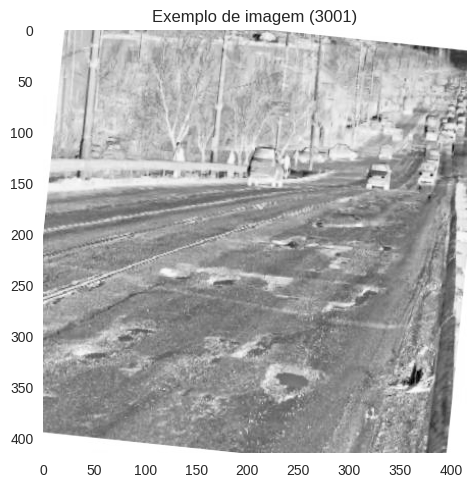

In [ ]:
img_data_train = read_images(org_path = "dataset-pothole/dataset/train", n_img = 10000)
yolo_data_train = read_annotations(org_path = "dataset-pothole/dataset/train", n_img = 10000)

##XGBoost Training

In [ ]:
# def train_model(img_data, yolo_data):
model = XGBClassifier()
# model = RandomForestClassifier(random_state=1)
n_images = 200

for i in range(8):
  x_train, y_train = prepare_data(img_data_train[i*n_images:(i+1)*n_images], yolo_data_train[i*n_images:(i+1)*n_images], window_size, window_step)

  trainX = prepare_images(x_train)
  trainY = y_train

  print('Treinando...')
  if i==0: model.fit(trainX, trainY)
  else: model.fit(trainX, trainY, xgb_model='xgboost.model')
  model.save_model('xgboost.model')

Train specitfic data:  (492, 80, 80)  Labels:  (492,)
Train augmmented specitfic data:  (5412, 80, 80)  Labels:  (5412,)
Train data:  (12885, 80, 80)  Labels:  (12885,)
Treinando...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:25:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Train specitfic data:  (507, 80, 80)  Labels:  (507,)
Train augmmented specitfic data:  (5577, 80, 80)  Labels:  (5577,)
Train data:  (13357, 80, 80)  Labels:  (13357,)
Treinando...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:30:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Train specitfic data:  (393, 80, 80)  Labels:  (393,)
Train augmmented specitfic data:  (4323, 80, 80)  Labels:  (4323,)
Train data:  (11662, 80, 80)  Labels:  (11662,)
Treinando...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:35:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Train specitfic data:  (487, 80, 80)  Labels:  (487,)
Train augmmented specitfic data:  (5357, 80, 80)  Labels:  (5357,)
Train data:  (13171, 80, 80)  Labels:  (13171,)
Treinando...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:40:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Train specitfic data:  (425, 80, 80)  Labels:  (425,)
Train augmmented specitfic data:  (4675, 80, 80)  Labels:  (4675,)
Train data:  (12476, 80, 80)  Labels:  (12476,)
Treinando...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:46:15] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Train specitfic data:  (528, 80, 80)  Labels:  (528,)
Train augmmented specitfic data:  (5808, 80, 80)  Labels:  (5808,)
Train data:  (13151, 80, 80)  Labels:  (13151,)
Treinando...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:52:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Train specitfic data:  (486, 80, 80)  Labels:  (486,)
Train augmmented specitfic data:  (5346, 80, 80)  Labels:  (5346,)
Train data:  (13056, 80, 80)  Labels:  (13056,)
Treinando...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:57:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Train specitfic data:  (336, 80, 80)  Labels:  (336,)
Train augmmented specitfic data:  (3696, 80, 80)  Labels:  (3696,)
Train data:  (10112, 80, 80)  Labels:  (10112,)
Treinando...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:02:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


##Read Testing Dataset

Total de imagens:  421
Tamano das imagens:  (416, 416)
Exemplo de anotação:  [0.0, 0.49278846153846156, 0.30649038461538464, 0.45072115384615385, 0.22235576923076922]


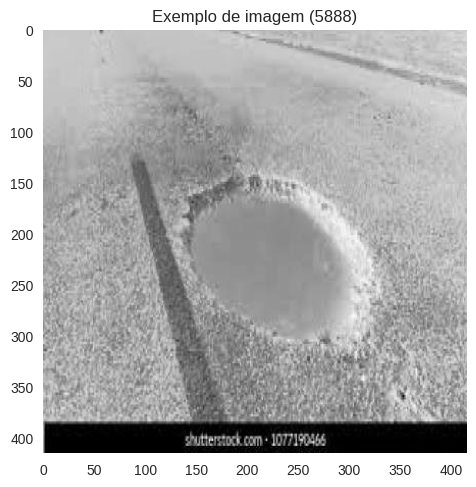

In [ ]:
img_data_test = read_images(org_path = "dataset-pothole/dataset/test", n_img=10000)
yolo_data_test = read_annotations(org_path = "dataset-pothole/dataset/test", n_img=10000)

##ROC Curve

Train specitfic data:  (875, 80, 80)  Labels:  (875,)
Train augmmented specitfic data:  (9625, 80, 80)  Labels:  (9625,)
Train data:  (25617, 80, 80)  Labels:  (25617,)
[0, 1]


<ipython-input-91-c85c7fcd61eb>:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


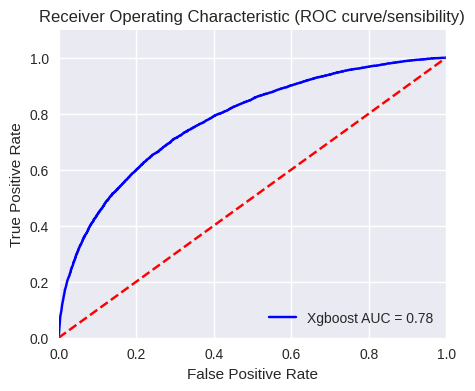

Accuracy: 
XGBoost=70.62% 

Sensitivity: 
XGBoost=71.75% 

Specificity: 
XGBoost=69.21% 

Auc_score: 
XGBoost=77.76% 



In [ ]:
model = XGBClassifier()
n_images = 10000
x_test, y_test = prepare_data(img_data_test[0:n_images], yolo_data_test[0:n_images], window_size, window_step)

testX = prepare_images(x_test)
testY = y_test

classNames = set(testY)
type(classNames)
classNames = list(classNames)
print(classNames)

model = XGBClassifier()
model.load_model("xgboost.model")

predictions = model.predict(testX)
predictions_probs = model.predict_proba(testX)
fpr, tpr, thresh = roc_curve(testY, predictions_probs[:,1])
cm = confusion_matrix(testY, predictions)
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / float(cm.sum())
sensitivity = tp / float(tp + fn)
specificity = tn / float(tn + fp)
auc_score = roc_auc_score(testY, predictions_probs[:,1])

plt.style.use("seaborn")
plt.figure(figsize=(5,4))
plt.title('Receiver Operating Characteristic (ROC curve/sensibility)')

plt.plot(fpr, tpr, color = 'blue', label = 'Xgboost AUC = {:.2f}'.format(auc_score))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('potholes', dpi = 300)
plt.show()

for metric in ("accuracy", "sensitivity", "specificity", "auc_score"):
    print(f"{metric.capitalize()}: ")
    print(f"XGBoost={globals()[metric]*100:.2f}% \n")

##Confusion Matrix

ACC:  0.7062497560213921


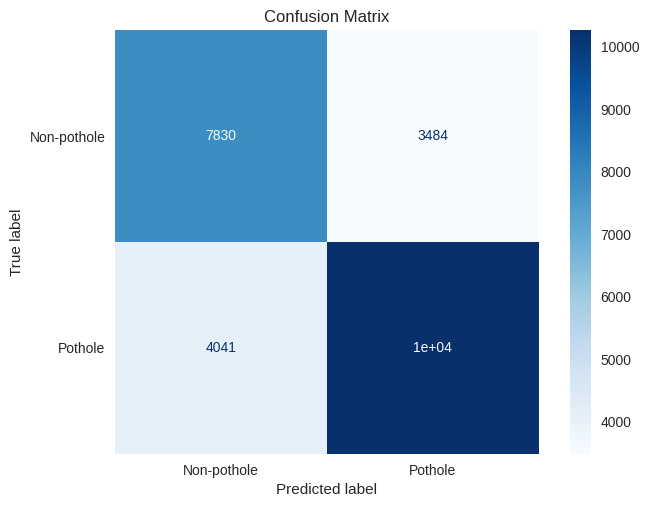

In [ ]:
# Plot Confusion Matrices for each ML Model
from sklearn.metrics import ConfusionMatrixDisplay

print('ACC: ', accuracy)
confusionMatrix = cm
classes = ['Non-pothole', 'Pothole']
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix,
                              display_labels=classes)

disp.plot(cmap='Blues')
plt.grid(False)
plt.title("Confusion Matrix")
plt.show()

##Testing Predictions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [ ]:
def coordinates_filter(coordinates):
  coordinates = np.column_stack((coordinates, np.sqrt(np.power(coordinates[:,0],2) + np.power(coordinates[:,1],2))))
  coordinates = coordinates[coordinates[:, 2].argsort()]

  j=0
  x_window = 0
  y_window = 0
  unique_coordinates = []
  unique_window = []

  for i in range(coordinates.shape[0]):
    if i==0 or (abs(coordinates[j,0] - coordinates[i,0]) > (window_size+x_window) or abs(coordinates[j,1] - coordinates[i,1]) > (window_size+y_window)):
      if j!=i:
        unique_window.append([window_size + x_window, window_size + y_window])
        x_window = 0
        y_window = 0
      j=i
      unique_coordinates.append(coordinates[j])
    else:
      if abs(coordinates[j,0] - coordinates[i,0]) < window_size+x_window:
        if abs(coordinates[j,0] - coordinates[i,0]) > x_window:
          x_window = abs(coordinates[j,0] - coordinates[i,0])
      if abs(coordinates[j,1] - coordinates[i,1]) < window_size+y_window:
        if abs(coordinates[j,1] - coordinates[i,1]) > y_window:
          y_window = abs(coordinates[j,1] - coordinates[i,1])
  unique_window.append([window_size + x_window, window_size + y_window])
  unique_coordinates = np.array((unique_coordinates))
  unique_window = np.array((unique_window))

  return unique_coordinates, unique_window

# unique_coordinates, unique_window = coordinates_filter(coordinates)

Number of windows with class 1:  12
Number of predictions:  7
Coodinates of predictions:  [[160, 120], [200, 120], [200, 160], [240, 160], [200, 200], [240, 200], [200, 240]]


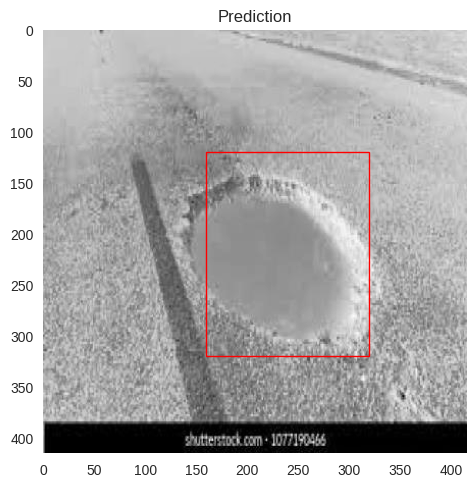

In [ ]:
def test_prediction(model, img, yolo_data):
    output_images = []
    coordinates = []
    j=0
    k=0
    if 1:
        window, window_class, position = sliding_windows(img, yolo_data, window_size, window_step)
        features = prepare_images(window)
        predictions = []

        for i in range(len(features)):
          preds = model.predict([features[i]])
          predictions.append(preds)
          if preds[0]:
              k=k+1
              coordinates.append(position[i])

    print("Number of windows with class 1: ",window_class.count(1))
    print("Number of predictions: ", k)
    print("Coodinates of predictions: ", coordinates)

    coordinates = np.array(coordinates)
    unique_coordinates, unique_window = coordinates_filter(coordinates)

    plt.imshow(img)
    plt.grid(False)
    plt.title("Prediction")
    if len(coordinates)>0:
      # plt.scatter(coordinates[:,0], coordinates[:,1], marker="x", color="red", s=20)
      for i, line in enumerate(unique_coordinates):
        rect = patches.Rectangle((line[0], line[1]), unique_window[i,0], unique_window[i,1], linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    return coordinates

n = 11
coordinates = test_prediction(model, img_data_test[n], yolo_data_test[n])